## Topic Modeling Using Twitter & LDA

In [1]:
#!pip install gensim
#!pip install wordcloud
#!pip install pyLDAvis

In [2]:
import tweepy
import pandas as pd
import json
import csv
import string
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
import datetime

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

from nltk.stem import WordNetLemmatizer, SnowballStemmer#PorterStemmer

from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

import nltk
nltk.download('wordnet')

import matplotlib.pyplot as pPlot
import seaborn as sb
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.colors as mcolors
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

[nltk_data] Downloading package wordnet to C:\Users\Yash
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
ACCESS_TOKEN="YOUR-TWITTER-ACCESS-TOKEN"
ACCESS_TOKEN_SECRET="YOUR-TOKEN-SECRET"
CONSUMER_API_KEY = "YOUR-CONSUMER-API-KEY"
CONSUMER_API_SECRET = "YOUR-CONSUMER-API-SECRET"

In [6]:
auth = tweepy.OAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True )

# 1) Collecting data

In [488]:
def saveToCSV(db_tweets):
    path = "C:/Users/Yash Raj/Python Projects_Sem3/3204 - Social Media Analytics/Assignment - 2/"
    filename = path + 'Nasa' + '.csv'
    
    if not os.path.isfile(filename):
        db_tweets.to_csv(filename)#, index=False, header='column_names'
    else:  # else it exists so append without mentioning the header
        db_tweets.to_csv(filename, mode='a', header=False, index=False)
        
    print('DataFrame Saved in',filename)

In [489]:
username = '@NASA'#'@Tokyo2020'#'cnni'
count = 5000

tweets_list = []

try:     
    print('Tweets scraping from', username,'account..')
    tweets = tweepy.Cursor(api.user_timeline,id=username,
                           include_rts = False, exclude_replies=True,
                           tweet_mode='extended').items(count)
        
    columns = ['username', 'location', 'createdAt',
               'text', 'hashtags']
    print("Fetching the required details..")

    tweets_count = 0
    for tweet in tweets:
        tweets_count = tweet.user.statuses_count
        break
        
    print("User",username,"tweeted",tweets_count,"tweets ever since.")
    # for tweet in tweet_list:
    tweets_list = [[tweet.user.screen_name, tweet.user.location,
                    tweet.created_at, tweet.full_text,
                    tweet.entities['hashtags']] for tweet in tweets]
    
    print('Total tweets fetched:',len(tweets_list))
    
    tweets_df = pd.DataFrame(tweets_list, columns=columns)
    print('DataFrame shape:',tweets_df.shape)
    print('Tweets Fetched Successfully..')
except BaseException as e:
      print('failed to fetch tweets, on_status,',str(e))
      time.sleep(3)

Tweets scraping from @NASA account..
Fetching the required details..
User @NASA tweeted 66077 tweets ever since.
Total tweets fetched: 1693
DataFrame shape: (1693, 5)
Tweets Fetched Successfully..


In [253]:
tweets_df

,username,location,createdAt,text,hashtags
0,NASA,Pale Blue Dot,2021-07-27 22:36:07,Thinking about food? So are we! 😋\n\nEarth-obs...,[]
1,NASA,Pale Blue Dot,2021-07-27 20:31:50,What's behind the atmosphere of Venus? To inve...,[]
2,NASA,Pale Blue Dot,2021-07-27 17:52:54,"""On the first orbital flight test, we learned ...",[]
3,NASA,Pale Blue Dot,2021-07-27 17:29:27,.@ISS_Research has supported:\n\n🔬Over 3000 sc...,[]
4,NASA,Pale Blue Dot,2021-07-27 17:21:57,When the @BoeingSpace Starliner docks to the @...,[]
...,...,...,...,...,...
1688,NASA,Pale Blue Dot,2020-11-07 02:03:15,This week...\n\n🎉 Celebrating the #SpaceStatio...,"[{'text': 'SpaceStation20th', 'indices': [32, ..."
1689,NASA,Pale Blue Dot,2020-11-07 00:06:02,"✨ A cosmic cascade: In this @NASAHubble image,...",[]
1690,NASA,Pale Blue Dot,2020-11-06 21:55:06,🛰️🌊 Let’s get wavy! A historic U.S.-European p...,"[{'text': 'SeeingTheSeas', 'indices': [264, 27..."
1691,NASA,Pale Blue Dot,2020-11-06 19:36:12,"On Nov. 14, four space travelers launch on a m...","[{'text': 'SpaceToGround', 'indices': [166, 18..."


In [254]:
saveToCSV(tweets_df)

DataFrame Saved in C:/Users/Yash Raj/Python Projects_Sem3/3204 - Social Media Analytics/Assignment - 2/Nasa.csv


#### Reloading Dataset from saved file

In [114]:
df= pd.read_csv('Nasa.csv', parse_dates=['createdAt'])
df.head()

,username,location,createdAt,text,hashtags
0,NASA,Pale Blue Dot,2021-07-27 22:36:07,Thinking about food? So are we! 😋\n\nEarth-obs...,[]
1,NASA,Pale Blue Dot,2021-07-27 20:31:50,What's behind the atmosphere of Venus? To inve...,[]
2,NASA,Pale Blue Dot,2021-07-27 17:52:54,"""On the first orbital flight test, we learned ...",[]
3,NASA,Pale Blue Dot,2021-07-27 17:29:27,.@ISS_Research has supported:\n\n🔬Over 3000 sc...,[]
4,NASA,Pale Blue Dot,2021-07-27 17:21:57,When the @BoeingSpace Starliner docks to the @...,[]


# 2) Data cleaning

In [115]:
def remove_duplicates(df):
    # dropping ALL duplicte values 
    df.drop_duplicates(subset ="text", 
                         keep = False, inplace = True) 
    return df   

In [116]:
def remove_2_words_tweet(df):
    df = df['text'].apply(lambda x:np.NaN if len(x)<=2 else x)
    return df

In [117]:
def removing_punctuations(tweets_txt):
    puntuation_filtered_txt = tweets_txt.translate(str.maketrans("","",string.punctuation))
    return puntuation_filtered_txt

In [118]:
def remove_numbers(tweets_txt):
    pattern = r"\d+"
    number_filter_txt = re.sub(pattern,"",tweets_txt)
    return number_filter_txt

### Removing duplicate tweets

In [119]:
df=remove_duplicates(df)

### Removing Punctuations

In [120]:
df['text']=df.apply(lambda x: removing_punctuations(x['text']),axis=1)

### Removing numbers 

In [121]:
df['text']=df.apply(lambda x: remove_numbers(x['text']),axis=1)

In [122]:
df.head()

,username,location,createdAt,text,hashtags
0,NASA,Pale Blue Dot,2021-07-27 22:36:07,Thinking about food So are we 😋\n\nEarthobserv...,[]
1,NASA,Pale Blue Dot,2021-07-27 20:31:50,Whats behind the atmosphere of Venus To invest...,[]
2,NASA,Pale Blue Dot,2021-07-27 17:52:54,On the first orbital flight test we learned a ...,[]
3,NASA,Pale Blue Dot,2021-07-27 17:29:27,ISSResearch has supported\n\n🔬Over science ex...,[]
4,NASA,Pale Blue Dot,2021-07-27 17:21:57,When the BoeingSpace Starliner docks to the Sp...,[]


### Removing words with length less than 2

In [123]:
df['text']=remove_2_words_tweet(df)

# 3) Visualizing the data

### Sorting dataframe date wise


In [124]:
df.sort_values(by=["createdAt"], inplace=True, ascending=False)
df

,username,location,createdAt,text,hashtags
0,NASA,Pale Blue Dot,2021-07-27 22:36:07,Thinking about food So are we 😋\n\nEarthobserv...,[]
1,NASA,Pale Blue Dot,2021-07-27 20:31:50,Whats behind the atmosphere of Venus To invest...,[]
2,NASA,Pale Blue Dot,2021-07-27 17:52:54,On the first orbital flight test we learned a ...,[]
3,NASA,Pale Blue Dot,2021-07-27 17:29:27,ISSResearch has supported\n\n🔬Over science ex...,[]
4,NASA,Pale Blue Dot,2021-07-27 17:21:57,When the BoeingSpace Starliner docks to the Sp...,[]
...,...,...,...,...,...
1688,NASA,Pale Blue Dot,2020-11-07 02:03:15,This week\n\n🎉 Celebrating the SpaceStationth ...,"[{'text': 'SpaceStation20th', 'indices': [32, ..."
1689,NASA,Pale Blue Dot,2020-11-07 00:06:02,✨ A cosmic cascade In this NASAHubble image ga...,[]
1690,NASA,Pale Blue Dot,2020-11-06 21:55:06,🛰️🌊 Let’s get wavy A historic USEuropean partn...,"[{'text': 'SeeingTheSeas', 'indices': [264, 27..."
1691,NASA,Pale Blue Dot,2020-11-06 19:36:12,On Nov four space travelers launch on a missi...,"[{'text': 'SpaceToGround', 'indices': [166, 18..."


### i) Plotting frequency of tweets

In [125]:
def plot5minFreqGraph(df,name):
    tweet_df_5min = df.groupby(pd.Grouper(key='createdAt', freq='5Min', convention='start')).size()
    tweet_df_5min.plot(figsize=(18,6))#, color='orange')
    plt.ylabel('Tweet Count', fontsize=16)
    plt.xlabel('Created At', fontsize=16)
    plt.title('#'+name+" Tweet Freq. Count, November'20 to July'21", fontsize=18)
    plt.grid(True)

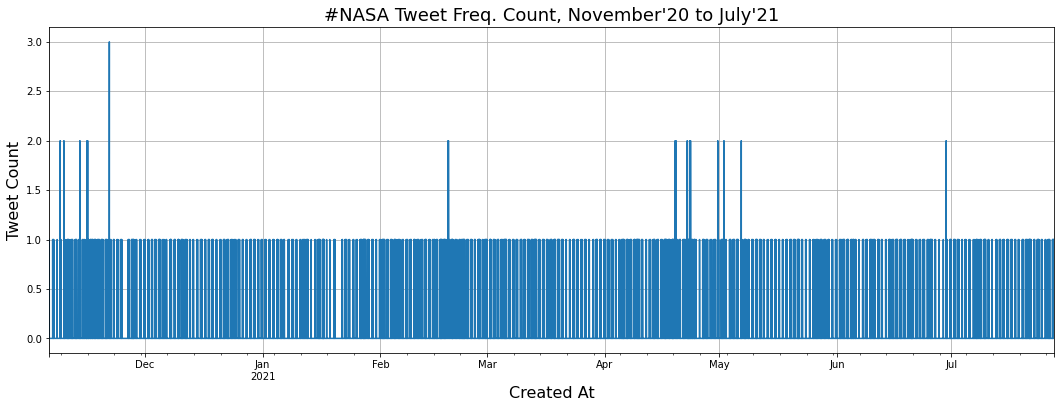

In [126]:
plot5minFreqGraph(df, 'NASA')#'CNN-International')

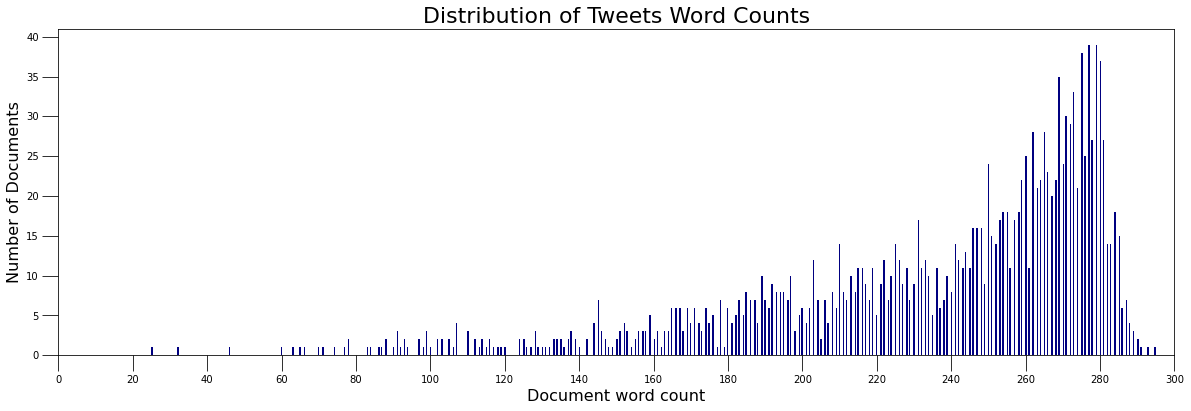

In [127]:
doc_lens = [len(d) for d in df.text]

# Plot
plt.figure(figsize=(20,6))
# sns.countplot(doc_lens)

plt.hist(doc_lens, bins = 700, color='navy')

plt.gca().set(xlim=(0, 300), ylabel='Number of Documents', xlabel='Document Word Count')#, fontsize =16)
plt.xlim(0,300)
plt.ylabel('Number of Documents', fontsize=16)
plt.xlabel('Document word count', fontsize=16)
plt.tick_params(size=16)
plt.xticks(np.linspace(0,300,16))
plt.title('Distribution of Tweets Word Counts', fontdict=dict(size=22))
plt.show()


In [128]:
data_text = pd.DataFrame()
data_text['text'] = df['text']

data_text['index'] = data_text.index
documents = data_text

In [129]:
print(len(documents))
print(documents[:5])

1693
                                                text  index
0  Thinking about food So are we 😋\n\nEarthobserv...      0
1  Whats behind the atmosphere of Venus To invest...      1
2  On the first orbital flight test we learned a ...      2
3  ISSResearch has supported\n\n🔬Over  science ex...      3
4  When the BoeingSpace Starliner docks to the Sp...      4


# 4) Data Pre-processing; Cleaning the tweets

In [130]:
def lemmatize_stemming(text):
    snowballStemm_ = SnowballStemmer(language='english')
    return snowballStemm_.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

### Select a document to preview after preprocessing.


In [131]:
doc_sample = documents[documents.index == 1].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Whats', 'behind', 'the', 'atmosphere', 'of', 'Venus', 'To', 'investigate', 'our', 'DAVINCI', 'mission', 'will', 'send', 'a', 'probe', 'with', 'a', 'suite', 'of', 'instruments', 'to', 'the', 'planets', 'surface', 'as', 'well', 'as', 'a', 'camera', 'to', 'capture', 'threedimensional', 'images', 'and', 'closeup', 'views', 'of', 'its', 'rugged', 'mountains', 'httpstcoEkgLZWbh', 'httpstcoFUOabeGVt']


 tokenized and lemmatized document: 
['what', 'atmospher', 'venus', 'investig', 'davinci', 'mission', 'send', 'probe', 'suit', 'instrument', 'planet', 'surfac', 'camera', 'captur', 'imag', 'closeup', 'view', 'rug', 'mountain']


### Preprocess the text, saving the results as ‘processed_docs’

In [132]:
processed_docs = documents['text'].apply(preprocess)
processed_docs[:10]

0    [think, food, earthobserv, satellit, help, far...
1    [what, atmospher, venus, investig, davinci, mi...
2    [orbit, flight, test, learn, learn, incorpor, ...
3    [issresearch, support, scienc, experi, countri...
4    [boeingspac, starlin, dock, spacest, mark, tim...
5    [boeingspac, starlin, spacecraft, look, beauti...
6    [live, watch, mission, expert, provid, latest,...
7    [upcom, orbit, flight, test, boeingspac, starl...
8    [cargo, deliveri, spacest, includ, experi, pri...
9    [today, curiousunivers, episod, entic, journey...
Name: text, dtype: object

### Bag of Words on the Data set


In [133]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 amount
1 crop
2 data
3 earthobserv
4 farmer
5 favorit
6 food
7 fruit
8 grain
9 grow
10 health


### Filter out tokens that appear in
- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 100000 most frequent tokens.


In [134]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

### Gensim doc2bow


In [135]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[100]

[(22, 1),
 (34, 1),
 (43, 1),
 (49, 1),
 (62, 1),
 (92, 1),
 (95, 1),
 (121, 2),
 (126, 1),
 (167, 1),
 (172, 1),
 (175, 1),
 (235, 1),
 (287, 1),
 (288, 1),
 (289, 1),
 (290, 1)]

### Preview Bag Of Words for our sample preprocessed document.

In [136]:
bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_100[i][0], 
                                               dictionary[bow_doc_100[i][0]], 
bow_doc_100[i][1]))


Word 22 ("flight") appears 1 time.
Word 34 ("spacest") appears 1 time.
Word 43 ("juli") appears 1 time.
Word 49 ("team") appears 1 time.
Word 62 ("cargo") appears 1 time.
Word 92 ("undock") appears 1 time.
Word 95 ("nasa") appears 1 time.
Word 121 ("spacex") appears 2 time.
Word 126 ("dragon") appears 1 time.
Word 167 ("plan") appears 1 time.
Word 172 ("control") appears 1 time.
Word 175 ("thur") appears 1 time.
Word 235 ("coverag") appears 1 time.
Word 287 ("continu") appears 1 time.
Word 288 ("monitor") appears 1 time.
Word 289 ("splashdown") appears 1 time.
Word 290 ("weather") appears 1 time.


### TF-IDF

In [137]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3004690961106936),
 (1, 0.451708165210966),
 (2, 0.451708165210966),
 (3, 0.2752929223479649),
 (4, 0.35560521847312193),
 (5, 0.3176330223556856),
 (6, 0.4455398835737394)]


# 5) Applying LDA for topic modeling; on 15 topics

### Running LDA using Bag of Words

In [138]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)

In [139]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.059*"spacest" + 0.032*"live" + 0.031*"spacewalk" + 0.029*"today" + 0.028*"watch" + 0.019*"launch" + 0.018*"spacecraft" + 0.017*"astrovicglov" + 0.016*"crew" + 0.014*"orbit"
Topic: 1 
Words: 0.023*"space" + 0.021*"launch" + 0.019*"satellit" + 0.018*"live" + 0.018*"mission" + 0.016*"nasa" + 0.016*"earth" + 0.015*"tune" + 0.015*"crew" + 0.014*"sentinel"
Topic: 2 
Words: 0.037*"live" + 0.025*"expert" + 0.023*"question" + 0.021*"space" + 0.020*"watch" + 0.017*"mar" + 0.016*"today" + 0.016*"explor" + 0.015*"nasapersever" + 0.015*"nasa"
Topic: 3 
Words: 0.039*"space" + 0.021*"spacest" + 0.021*"nasa" + 0.020*"moon" + 0.020*"mission" + 0.019*"launch" + 0.017*"earth" + 0.015*"crew" + 0.014*"year" + 0.013*"chang"
Topic: 4 
Words: 0.048*"spacest" + 0.035*"spacecraft" + 0.024*"launch" + 0.023*"earth" + 0.021*"cargo" + 0.020*"mission" + 0.019*"space" + 0.018*"watch" + 0.017*"live" + 0.015*"spacex"
Topic: 5 
Words: 0.031*"crew" + 0.027*"nasa" + 0.024*"mission" + 0.019*"astronaut" +

### Running LDA using TF-IDF

In [140]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.014*"crew" + 0.014*"launch" + 0.013*"nasa" + 0.013*"april" + 0.013*"mission" + 0.012*"astronaut" + 0.011*"nasapersever" + 0.011*"mar" + 0.011*"team" + 0.010*"test"
Topic: 1 Word: 0.017*"test" + 0.016*"imag" + 0.015*"spacecraft" + 0.012*"rocket" + 0.011*"nasasl" + 0.011*"dragon" + 0.010*"mission" + 0.010*"spacest" + 0.009*"crew" + 0.009*"asteroid"
Topic: 2 Word: 0.016*"galaxi" + 0.014*"star" + 0.012*"space" + 0.011*"administr" + 0.011*"nation" + 0.011*"inspir" + 0.011*"crew" + 0.010*"live" + 0.010*"planet" + 0.010*"explor"
Topic: 3 Word: 0.014*"crew" + 0.013*"take" + 0.013*"port" + 0.012*"live" + 0.012*"nasa" + 0.012*"mission" + 0.011*"spacest" + 0.011*"launch" + 0.011*"question" + 0.010*"answer"
Topic: 4 Word: 0.026*"launchamerica" + 0.022*"crew" + 0.018*"nasa" + 0.017*"spacex" + 0.015*"mission" + 0.015*"live" + 0.012*"spacest" + 0.012*"launch" + 0.012*"hole" + 0.011*"black"
Topic: 5 Word: 0.017*"moon" + 0.015*"earth" + 0.013*"space" + 0.012*"detail" + 0.012*"find" + 0

### Performance evaluation by classifying sample document using LDA Bag of Words model

In [141]:
processed_docs[100]

['undock',
 'spacex',
 'cargo',
 'dragon',
 'spacest',
 'plan',
 'thur',
 'juli',
 'coverag',
 'nasa',
 'spacex',
 'flight',
 'control',
 'team',
 'continu',
 'monitor',
 'weather',
 'splashdown',
 'locat']

In [142]:
for index, score in sorted(lda_model[bow_corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9508758783340454	 
Topic: 0.033*"nasa" + 0.030*"spacest" + 0.024*"crew" + 0.022*"spacecraft" + 0.021*"mission" + 0.018*"learn" + 0.018*"spacex" + 0.018*"updat" + 0.015*"dragon" + 0.014*"team"


### Performance evaluation by classifying sample document using LDA TF-IDF model.

In [143]:
for index, score in sorted(lda_model_tfidf[bow_corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6086517572402954	 
Topic: 0.015*"live" + 0.015*"mission" + 0.014*"dragon" + 0.014*"spacex" + 0.013*"nasa" + 0.013*"test" + 0.013*"crew" + 0.013*"flight" + 0.012*"marshelicopt" + 0.012*"watch"

Score: 0.345731645822525	 
Topic: 0.014*"crew" + 0.013*"take" + 0.013*"port" + 0.012*"live" + 0.012*"nasa" + 0.012*"mission" + 0.011*"spacest" + 0.011*"launch" + 0.011*"question" + 0.010*"answer"


### Testing model on unseen document

In [144]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.06666667014360428	 Topic: 0.059*"spacest" + 0.032*"live" + 0.031*"spacewalk" + 0.029*"today" + 0.028*"watch"
Score: 0.06666667014360428	 Topic: 0.023*"space" + 0.021*"launch" + 0.019*"satellit" + 0.018*"live" + 0.018*"mission"
Score: 0.06666667014360428	 Topic: 0.037*"live" + 0.025*"expert" + 0.023*"question" + 0.021*"space" + 0.020*"watch"
Score: 0.06666667014360428	 Topic: 0.039*"space" + 0.021*"spacest" + 0.021*"nasa" + 0.020*"moon" + 0.020*"mission"
Score: 0.06666667014360428	 Topic: 0.048*"spacest" + 0.035*"spacecraft" + 0.024*"launch" + 0.023*"earth" + 0.021*"cargo"
Score: 0.06666667014360428	 Topic: 0.031*"crew" + 0.027*"nasa" + 0.024*"mission" + 0.019*"astronaut" + 0.018*"spacest"
Score: 0.06666667014360428	 Topic: 0.056*"crew" + 0.033*"spacest" + 0.031*"star" + 0.029*"mission" + 0.024*"spacex"
Score: 0.06666667014360428	 Topic: 0.033*"nasa" + 0.030*"spacest" + 0.024*"crew" + 0.022*"spacecraft" + 0.021*"mission"
Score: 0.06666667014360428	 Topic: 0.025*"land" + 0.023*"

# 6) Word-Cloud

In [145]:
def fetchSelectedWords(model):
    x=model.show_topics(num_topics=15, num_words=10,formatted=False)
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

    top_10 = ""
    #Below Code Prints Only Words 
    for topic,words in topics_words:
        top_10 = top_10+" ".join(words)
    return top_10

def displayWordCloud(data):
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="black", max_words=1000).generate(data)
    # rcParams['figure.figsize'] = 10, 20
    plt.figure(figsize =(20, 7) )

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### i) LDA using bag of words

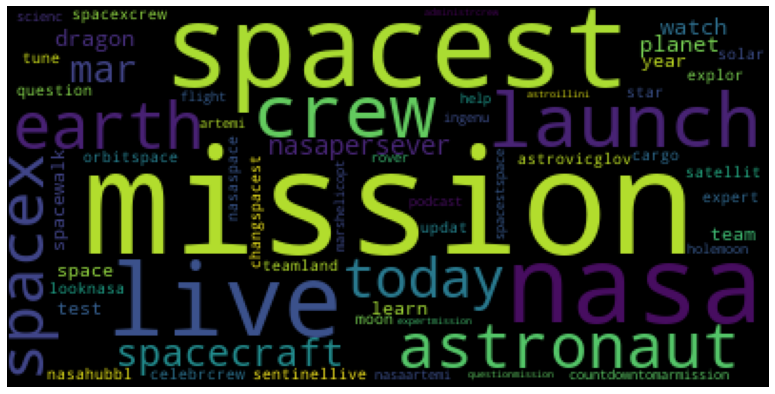

In [146]:
lda_bow_data = fetchSelectedWords(lda_model)
displayWordCloud(lda_bow_data)

### ii) LDA using Tf-idf

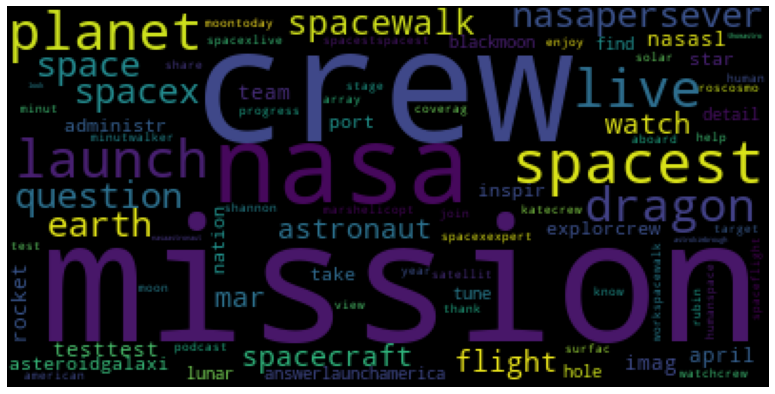

In [147]:
lda_tfidf_data = fetchSelectedWords(lda_model_tfidf)
displayWordCloud(lda_tfidf_data)

### iii) Python LDA Visualization

In [149]:
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(df.text)
data_matrix

<1693x1895 sparse matrix of type '<class 'numpy.int64'>'
	with 26188 stored elements in Compressed Sparse Row format>

In [152]:
lda_model_temp = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model_temp.fit_transform(data_matrix)

In [153]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model_temp, data_matrix, vectorizer, mds='tsne')

C:\Users\Yash Raj\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\Yash Raj\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  16.834377
0       0.648955  71.707100       2        1  16.579144
4      71.019684   9.971006       3        1  12.088556
5       3.785981  33.185135       4        1  10.837598
6     -42.666500  -9.222070       5        1  10.006383
1      -3.621689 -43.526516       6        1   9.615153
3      -3.632402  -4.171708       7        1   8.113214
8     -36.584400  35.804413       8        1   7.326508
7      44.391380  50.615383       9        1   6.031787
2      40.235809 -31.591665      10        1   2.567280, topic_info=               Term        Freq       Total Category  logprob  loglift
364            crew  398.000000  398.000000  Default  30.0000  30.0000
1569         spacex  263.000000  263.000000  Default  29.0000  29.0000
1006           mars  177.000000  177.000000  Default  28.0000  28.0000
1560   spacestation  457.000000  457.000000  Default  27.0000  27.0000
1106  nasapersevere  134.000000  134.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1537          solar    7.891176  111.247260  Topic10  -4.4846   1.0163
881            july    5.444169   31.420924  Topic10  -4.8558   1.9094
1551          soyuz    5.395281   30.480713  Topic10  -4.8648   1.9308
1560   spacestation    5.473199  457.053610  Topic10  -4.8505  -0.7626
1552          space    5.320398  283.379543  Topic10  -4.8788  -0.3129

[576 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.572732  aboard
2         2  0.225622  aboard
2         4  0.069422  aboard
2         5  0.026033  aboard
2         6  0.017356  aboard
...     ...       ...     ...
1887      4  0.017885   years
1887      6  0.214621   years
1887      9  0.554439   years
1891      1  0.872217   youre
1891      6  0.067094   youre

[907 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 5, 6, 7, 2, 4, 9, 8, 3])

# 7) Display the related tweets from the user input word

In [80]:
def searchTweets(input):
    results = []
    i = 0
    print('\n')

    for idx, topics in enumerate(processed_docs):
        if input in topics:
            results.append(documents['text'][idx]+'\n')
        else:
            user_input = preprocess(input)
            user_input = " ".join(user_input)
            if user_input in topics:
                results.append(documents['text'][idx]+'\n')

    count = 0
    if len(results)>0:
        for i in results:
            print('Tweet',count+1,':',i)
            count+=1
    else:
        print("No results found matching '"+input+"' word")
    

In [81]:
user_input = input("Please enter random word:")
searchTweets(user_input)

Please enter random word:venus


Tweet 1 : Whats behind the atmosphere of Venus To investigate our DAVINCI mission will send a probe with a suite of instruments to the planets surface as well as a camera to capture threedimensional images and closeup views of its rugged mountains httpstcoEkgLZWbh httpstcoFUOabeGVt

Tweet 2 : In this new episode of the GravityAssist podcast our Chief Scientist Jim Green is joined by Director of Planetary Science Lori Glaze to discuss three upcoming missions to planet Venus and their excitement for the science to come 

🎙️ Check it out now httpstcoaKlHmsgvl httpstcokzTRhfm

Tweet 3 : Sunsets in July come with an added bonus Venus blazing as the “‘Evening Star” low in the western sky 

🌌 Plus if you can find your way to dark skies this is the best time of year to enjoy the magic of the Milky Way 

Enjoy more July skywatching tips httpstcogOwGIlZvC httpstcohCYaLCzUu

Tweet 4 : In a “triple crown” moment for Venus science community a third mission EnVision 

# 8) Bar Diagram showing the top-5 topics for any Twitter handler of your choice

In [175]:
def getTop5Topics(model):
    x=model.show_topics(num_topics=5,formatted=False)
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

    top_5 = []
    #Below Code Prints Only Words 
    for topic,words in topics_words:
        top_5.append(" ".join(words))
    return top_5

def coherence(model_, processed_docs, vectorizer, id2word):
    texts = [word for tokens in df['text'] for word in processed_docs]
    
    coherence_model_lda = CoherenceModel(model=lda_model, topics=processed_docs, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)#coherence_model_lda)#


def findLDAScore(model, top5Topics_lda):
    score_list=[]
    for topic in top5Topics_lda:
        bow_vector = dictionary.doc2bow(preprocess(topic))
        for index, score in sorted(model[bow_vector], key=lambda tup: -1*tup[1]):
            score = int(round(score,2)*100)
            #print(score)
            score_list.append(score)
            break
            #print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))
    return score_list


def top5TopicsBarChart(labels, score, title):
    
    #my_colors = ['black', 'red', 'green', 'blue', 'purple']#, 'grey', 'maroon', 'salmon', 'yellow','pink']
    color = ['blue','orange','green','red','purple']
    f = plt.figure(figsize =(15, 5) )

    ax = plt.subplot(111) #specify a subplot #plt.subplots(111, figsize=(8,6))#

    count = 0
    index = [1,2,3,4,5]
    
    graph = ax.bar(index, score, label = labels, color = color, alpha=0.5)
    
    for p in graph:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10,
               s="{}%".format(height),
               ha='center', weight='bold', fontsize=16)
        

    ax=plt.gca()

    ax.set_xlabel("Topics", fontsize=18, labelpad=5, color='maroon')
    ax.set_ylabel("Topics Score", fontsize=18, labelpad=5, color='maroon')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.title(title, fontsize=16)#"Top 5 topics", fontsize=16)

    #plt.legend(labels, loc="best",frameon=False, bbox_to_anchor=(0.5, -0.3))
    ax.legend(graph, labels, loc="center",
              frameon=False, bbox_to_anchor=(0.5, -0.3))

    
    plt.show()

In [171]:
id2word = corpora.Dictionary(processed_docs)
coherence(lda_model,processed_docs, vectorizer, id2word)


Coherence Score:  0.7767472040137553


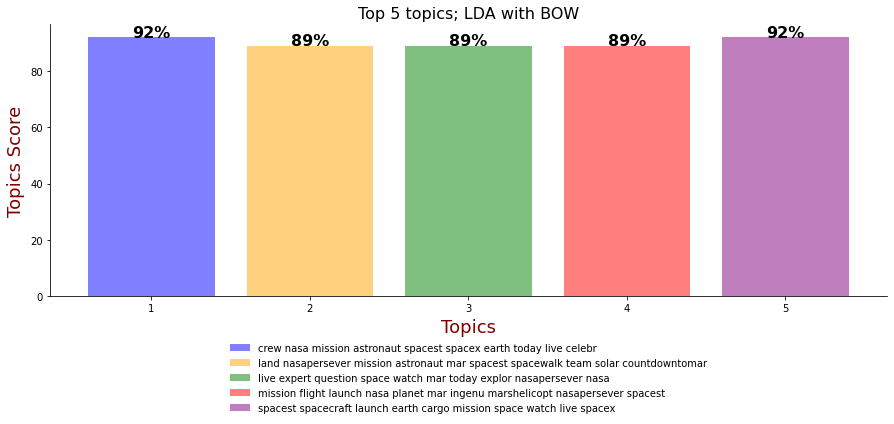

In [183]:
top5Topics_lda = getTop5Topics(lda_model)
score = findLDAScore(lda_model, top5Topics_lda)

top5TopicsBarChart(top5Topics_lda, score, 'Top 5 topics; LDA with BOW')

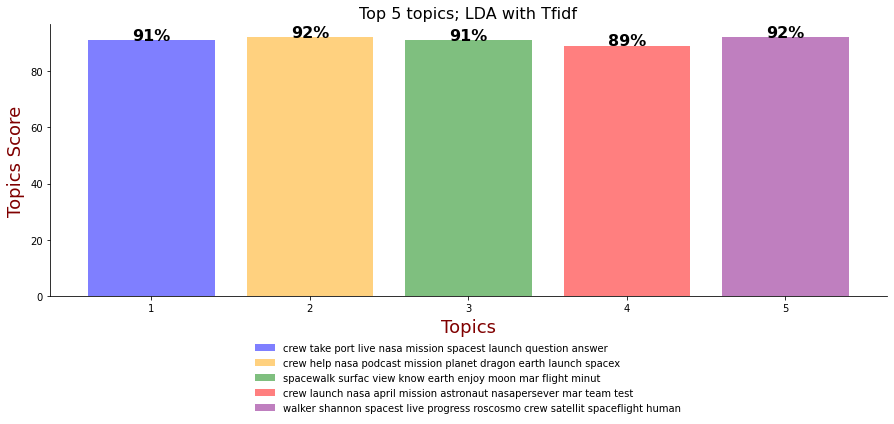

In [186]:
top5Topics_lda_tfidf = getTop5Topics(lda_model_tfidf)
score = findLDAScore(lda_model_tfidf, top5Topics_lda_tfidf)

top5TopicsBarChart(top5Topics_lda_tfidf, score, 'Top 5 topics; LDA with Tfidf')
